# **⭕Lung Tumor Detection And Segmentation Notebook**



# **✅Dataset Description:**

## **Problem:**


---


### Dataset: Train and Validation folder.
### Every folder of train/val have another folders for images, masks and detections.
### Every folder of images/masks/detections have number of patients data.
### Every patient have huge number of images data.

## **Solution:**

---


### 1-Task1: Apply and Train Yolo Object Detection Model.
### 2-Task2: Apply and Train UNet Segmentation Model for full images.
### 3-Task3: Apply and Train UNet Segmentation Model for cropped detection image.
### 4-Task4: Performance of valid data and Decide which technique is the best from 2 or 3?


---

# **✅Import Libraries:**

In [ ]:
%pip install ultralytics
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 22.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from seaborn import color_palette

import os
import zipfile
import cv2
import random
import shutil
import yaml
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# **✅Dataset Overview:**

In [ ]:
def extract_zip(zip_path, extract_to):

    # Check if the extraction folder exists, if not, create it
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    # Extract the contents of the ZIP file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

zip_path = '/content/LungTumorDetectionAndSegmentation.zip'
extract_to = '/content/LungTumorDetectionAndSegmentation'
extract_zip(zip_path, extract_to)


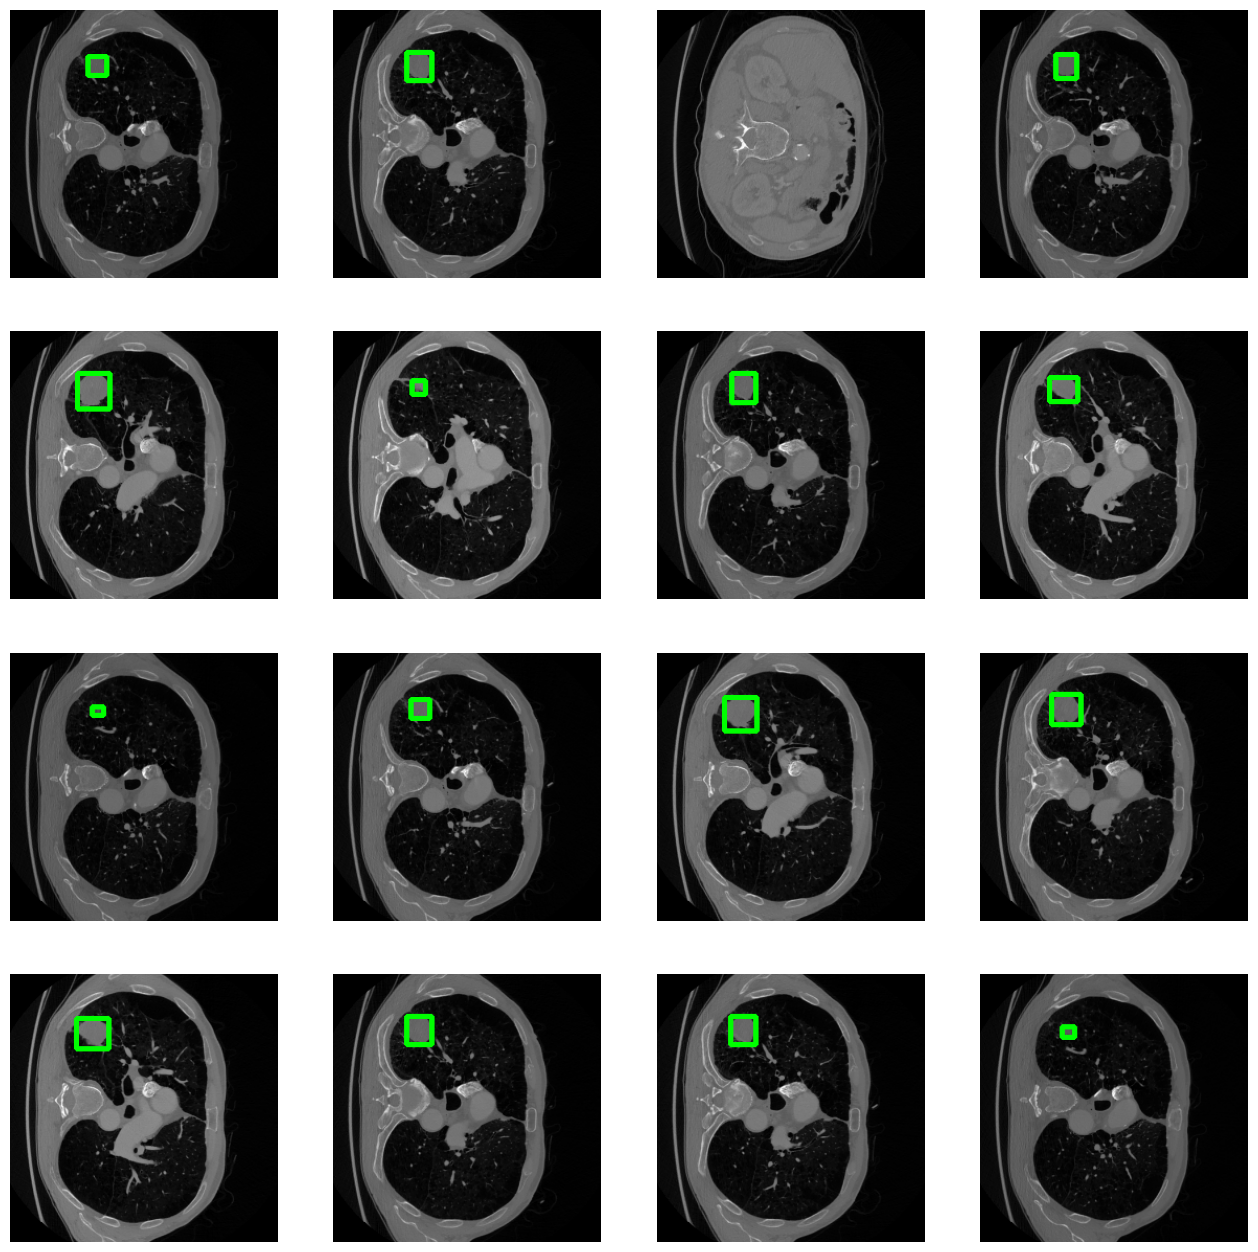

In [ ]:
train_images = "/content/LungTumorDetectionAndSegmentation/train/images/Subject_0"
train_labels = "/content/LungTumorDetectionAndSegmentation/train/detections/Subject_0"

image_files = os.listdir(train_images)

random_images = random.sample(image_files, 16)

fig, axs = plt.subplots(4, 4, figsize=(16, 16))

for i, image_file in enumerate(random_images):
    row, col = divmod(i, 4)

    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            labels = f.read().strip().split("\n")

        for label in labels:
            xmin, ymin, xmax, ymax = map(int, label.split(','))
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)

    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()


In [ ]:
# Get the size of the image
height, width, channels = image.shape
print(f"The image has dimensions {width}x{height} and {channels} channels.")

The image has dimensions 256x256 and 3 channels.


# **✅Dataset Loading:**

In [ ]:
class DataLoader:
    def __init__(self, train_path='/content/LungTumorDetectionAndSegmentation/train/', val_path='/content/LungTumorDetectionAndSegmentation/val/'):
        '''Loads training and validation data'''
        self.train_path = train_path
        self.val_path = val_path

        print('[ Loading Training Data ]  ', end='')
        self.train_data = self.load_all_data(self.train_path)
        print('Done')
        print('[ Loading Validation Data ]  ', end='')
        self.val_data = self.load_all_data(self.val_path)
        print('Done')

    def load_all_data(self, data_path):
        data = {}
        # Iterate over each patient in the images folder
        for patient in os.listdir(os.path.join(data_path, 'images/')):
            patient_images_path = os.path.join(data_path, 'images/', patient)
            patient_masks_path = os.path.join(data_path, 'masks/', patient)
            patient_detections_path = os.path.join(data_path, 'detections/', patient)

            for image_name in os.listdir(patient_images_path):
                image_path = os.path.join(patient_images_path, image_name)
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                scan_ID = f"{patient}_{os.path.splitext(image_name)[0]}"
                data[scan_ID] = [img]  # Initialize with the image

                # Add corresponding mask and detection
                mask_path = os.path.join(patient_masks_path, f"{os.path.splitext(image_name)[0]}.png")
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    data[scan_ID].append(mask)

                detection_path = os.path.join(patient_detections_path, f"{os.path.splitext(image_name)[0]}.txt")
                if os.path.exists(detection_path):
                    detections = self.read_detections(detection_path)
                    data[scan_ID].append(detections)

        # Ensure every scan has three elements (image, mask, detections)
        for scan in data.values():
            if len(scan) == 2:
                scan.append([])  # Add empty list for missing detections
        return data

    def read_detections(self, path):
        detections = []
        if os.path.exists(path):
            with open(path, 'r') as file:
                detections = [tuple(map(int, line.split(','))) for line in file]
        return detections

    def filter_valid_detection_images(self, image_dir, detection_dir):
        valid_images_tumor = []
        valid_images_no_tumor = []

        for subject in sorted(os.listdir(image_dir)):
            subject_image_dir = os.path.join(image_dir, subject)
            subject_detection_dir = os.path.join(detection_dir, subject)

            if os.path.isdir(subject_image_dir) and os.path.isdir(subject_detection_dir):
                for image_file in os.listdir(subject_image_dir):
                    if image_file.endswith(('.png', '.jpg')):
                        detection_file = os.path.join(subject_detection_dir, image_file.replace('.png', '.txt').replace('.jpg', '.txt'))

                        if os.path.exists(detection_file) and os.stat(detection_file).st_size > 0:
                            valid_images_tumor.append(os.path.join(subject_image_dir, image_file))
                        else:
                            valid_images_no_tumor.append(os.path.join(subject_image_dir, image_file))

        return valid_images_tumor, valid_images_no_tumor


# Initialize DataLoader
train_file = '/content/LungTumorDetectionAndSegmentation/train'
val_file = '/content/LungTumorDetectionAndSegmentation/val'
image_train_file = '/content/LungTumorDetectionAndSegmentation/train/images'
detections_train_file = '/content/LungTumorDetectionAndSegmentation/train/detections'
image_val_file = '/content/LungTumorDetectionAndSegmentation/val/images'
detections_val_file = '/content/LungTumorDetectionAndSegmentation/val/detections'

# Load the data
load_all_data = DataLoader(train_path=train_file, val_path=val_file)

# Test loading data
print("\nTesting load_data:")
print(f"Training Data: {len(load_all_data.train_data)}")
print(f"Validation Data: {len(load_all_data.val_data)}")

# Test filtering valid images
print("\nTesting filter_valid_images:")
train_images_with_tumor, train_images_no_tumor = load_all_data.filter_valid_detection_images(image_train_file, detections_train_file)
val_images_with_tumor, val_images_no_tumor = load_all_data.filter_valid_detection_images(image_val_file, detections_val_file)

print(f"Number of training images: tumor {len(train_images_with_tumor)}, no tumor {len(train_images_no_tumor)}")
print(f"Number of validation images: tumor {len(val_images_with_tumor)}, no tumor {len(val_images_no_tumor)}")

[ Loading Training Data ]  Done
[ Loading Validation Data ]  Done

Testing load_data:
Training Data: 1832
Validation Data: 98

Testing filter_valid_images:
Number of training images: tumor 1547, no tumor 285
Number of validation images: tumor 78, no tumor 20


# **⚡Task1: Object Detection...**

## **✅Training Yolo Model:**

**Yolo** is an algorithm that uses convolutional neural networks for object detection.
Detection algorithm does not only predict class labels, but detects locations of objects as well.

In [ ]:
def process_annotations_to_yolo(image_folder, annotation_folder, output_folder, class_id, image_width, image_height):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Loop through all subjects in the image folder
    for subject_folder in sorted(os.listdir(image_folder)):
        subject_path = os.path.join(image_folder, subject_folder)
        annotation_subject_path = os.path.join(annotation_folder, subject_folder)

        if os.path.isdir(subject_path):  # Process only directories
            subject_output_folder = os.path.join(output_folder, subject_folder)
            os.makedirs(subject_output_folder, exist_ok=True)

            # Process all images in the subject folder
            for image_file in sorted(os.listdir(subject_path)):
                if image_file.endswith(('.jpg', '.png', '.jpeg')):
                    process_image(image_file, subject_path, annotation_subject_path, subject_output_folder, class_id, image_width, image_height)

def process_image(image_file, subject_path, annotation_subject_path, subject_output_folder, class_id, image_width, image_height):
    # Full path to the image and corresponding annotation
    image_file_path = os.path.join(subject_path, image_file)
    annotation_file_path = os.path.join(annotation_subject_path, f"{os.path.splitext(image_file)[0]}.txt")

    # Copy the image to the output folder
    shutil.copy(image_file_path, os.path.join(subject_output_folder, image_file))

    if os.path.exists(annotation_file_path):
        # Process the annotation file
        with open(annotation_file_path, 'r') as f:
            lines = f.readlines()

        # Convert to YOLO format
        yolo_annotations = []
        for line in lines:
            xmin, ymin, xmax, ymax = map(int, line.strip().split(','))
            x_center = (xmin + xmax) / 2 / image_width
            y_center = (ymin + ymax) / 2 / image_height
            width = (xmax - xmin) / image_width
            height = (ymax - ymin) / image_height

            yolo_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}")

        # Save the YOLO annotations
        output_annotation_file = os.path.join(subject_output_folder, f"{os.path.splitext(image_file)[0]}.txt")
        with open(output_annotation_file, 'w') as f:
            f.write('\n'.join(yolo_annotations))

# Parameters for training data
train_params = {
    'image_folder': '/content/LungTumorDetectionAndSegmentation/train/images',
    'annotation_folder': '/content/LungTumorDetectionAndSegmentation/train/detections',
    'output_folder': '/content/LungTumorDetectionAndSegmentation/train/actual_images_detections',
    'class_id': 1,
    'image_width': 256,
    'image_height': 256
}

# Process training data
process_annotations_to_yolo(**train_params)

# Parameters for validation data
val_params = {
    'image_folder': '/content/LungTumorDetectionAndSegmentation/val/images',
    'annotation_folder': '/content/LungTumorDetectionAndSegmentation/val/detections',
    'output_folder': '/content/LungTumorDetectionAndSegmentation/val/actual_images_detections',
    'class_id': 1,
    'image_width': 256,
    'image_height': 256
}

# Process validation data
process_annotations_to_yolo(**val_params)


**data.yaml** for Binary Classification You will only have two classes: one for images containing a tumor and one for images without a tumor.

In [ ]:
yaml_folder = '''
train: /content/LungTumorDetectionAndSegmentation/train/actual_images_detections
val: /content/LungTumorDetectionAndSegmentation/val/actual_images_detections
nc: 2
names: ['no_tumor', 'tumor']
'''

# Save the YAML to a file
with open("/content/dataset.yaml", "w") as file:
    file.write(yaml_folder)

# Now use the CLI format to train the model
!yolo train data=/content/dataset.yaml model=yolov8n.pt epochs=30 batch=16


100% 6.25M/6.25M [00:00<00:00, 93.0MB/s]
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

## **✅Performance Yolo Model:**

**Train Box Loss:**
The train box loss metric measures the difference between the predicted bounding boxes and the actual bounding boxes of the objects in the training data. A lower box loss means that the model's predicted bounding boxes more closely align with the actual bounding boxes.

**Train Class Loss:**
The train class loss metric measures the difference between the predicted class probabilities and the actual class labels of the objects in the training data. A lower class loss means that the model's predicted class probabilities more closely align with the actual class labels.

**Train DFL Loss:**
The train DFL (Dynamic Feature Learning) loss metric measures the difference between the predicted feature maps and the actual feature maps of the objects in the training data. A lower DFL loss means that the model's predicted feature maps more closely align with the actual feature maps.

**Metrics Precision (B):**
The metrics precision (B) metric measures the proportion of true positive detections among all the predicted bounding boxes. A higher precision means that the model is better at correctly identifying true positive detections and minimizing false positives.

**Metrics Recall (B):**
The metrics recall (B) metric measures the proportion of true positive detections among all the actual bounding boxes. A higher recall means that the model is better at correctly identifying all true positive detections and minimizing false negatives.

**Metrics mAP50 (B):**
The metrics mAP50 (B) metric measures the mean average precision of the model across different object categories, with a 50% intersection-over-union (IoU) threshold. A higher mAP50 means that the model is better at accurately detecting and localizing objects across different categories.

**Metrics mAP50-95 (B):**
The metrics mAP50-95 (B) metric measures the mean average precision of the model across different object categories, with IoU thresholds ranging from 50% to 95%. A higher mAP50-95 means that the model is better at accurately detecting and localizing objects across different categories with a wider range of IoU thresholds.

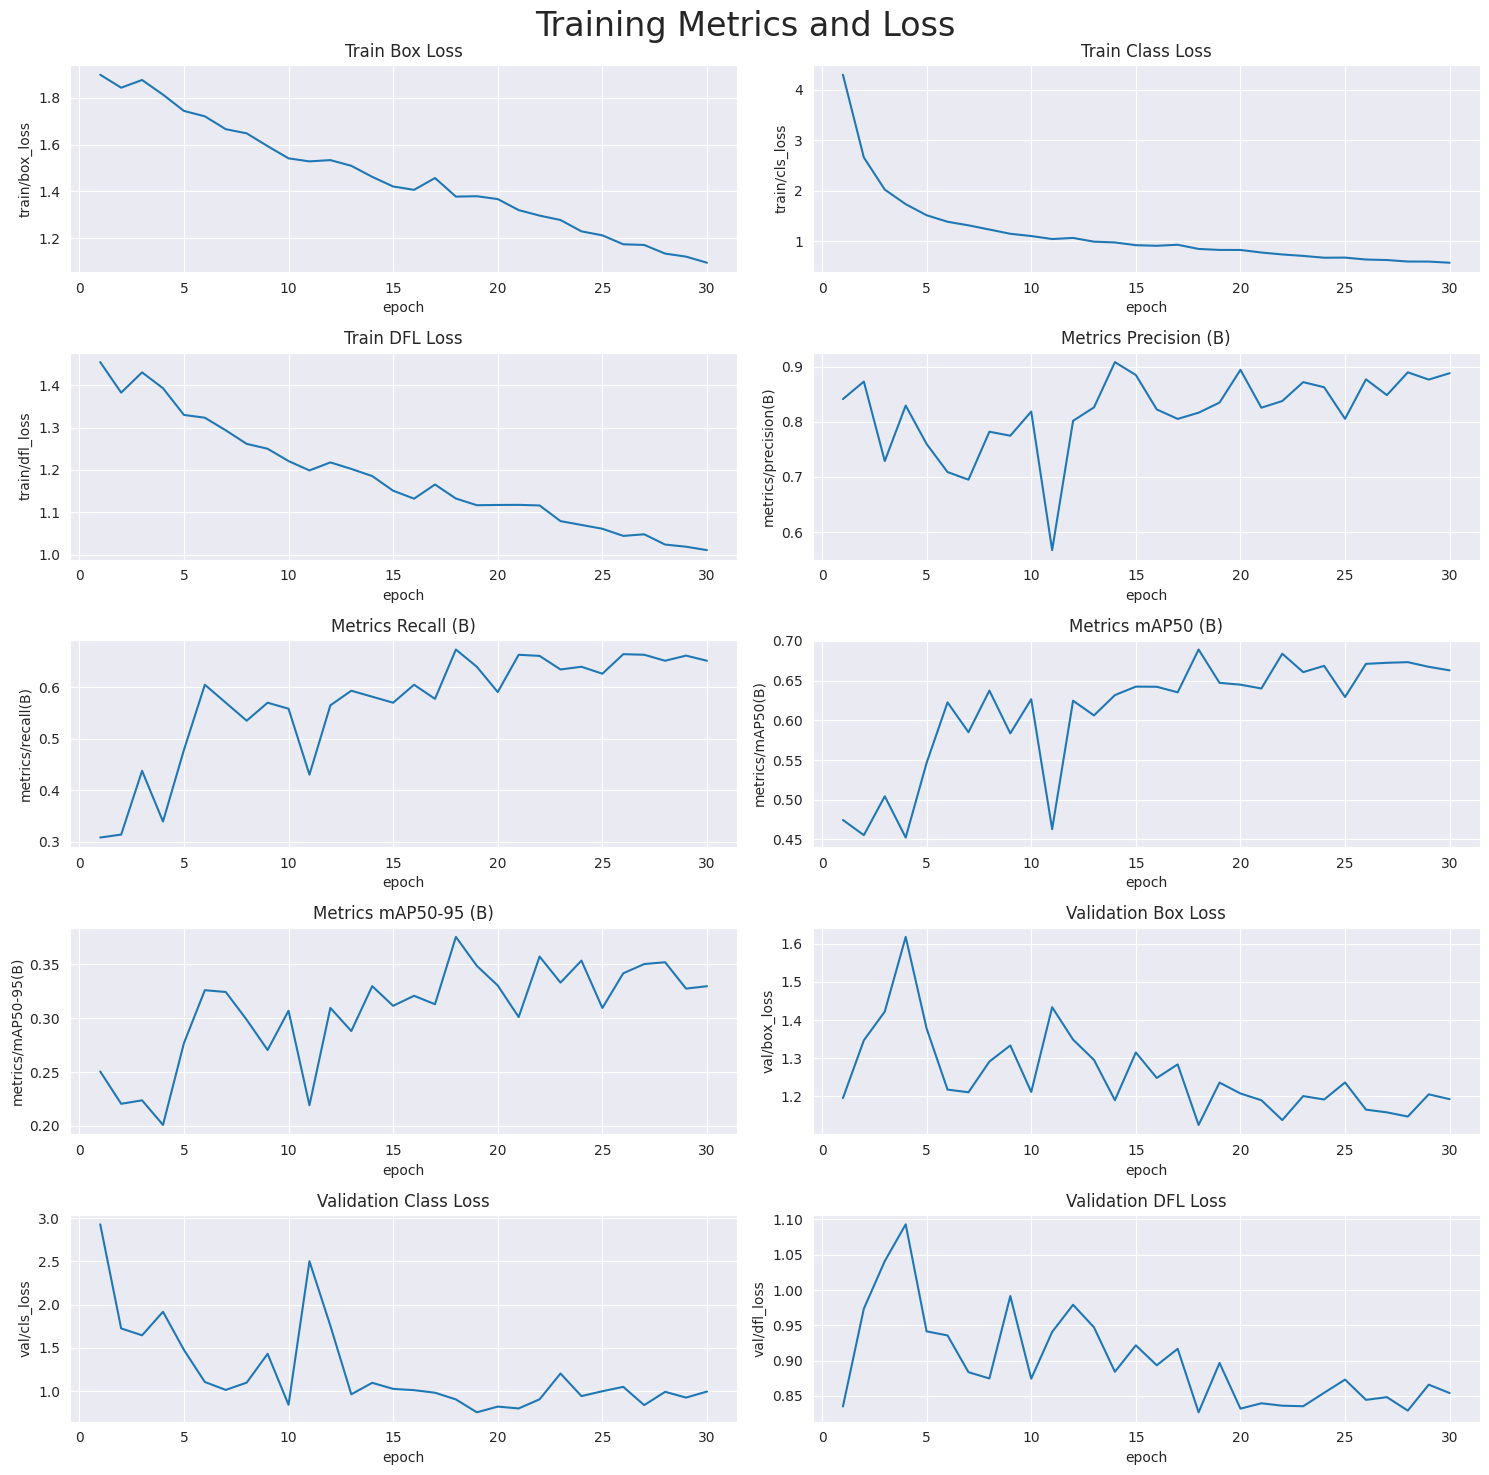

In [ ]:
# Read in the results.csv file as a pandas dataframe
df = pd.read_csv('/content/runs/detect/train/results.csv')
df.columns = df.columns.str.strip()

# Create subplots using seaborn (5 rows, 2 columns)
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# Plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0, 0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0, 1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1, 0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1, 1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2, 0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2, 1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3, 0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3, 1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4, 0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4, 1])

# Set titles and axis labels for each subplot
axs[0, 0].set(title='Train Box Loss')
axs[0, 1].set(title='Train Class Loss')
axs[1, 0].set(title='Train DFL Loss')
axs[1, 1].set(title='Metrics Precision (B)')
axs[2, 0].set(title='Metrics Recall (B)')
axs[2, 1].set(title='Metrics mAP50 (B)')
axs[3, 0].set(title='Metrics mAP50-95 (B)')
axs[3, 1].set(title='Validation Box Loss')
axs[4, 0].set(title='Validation Class Loss')
axs[4, 1].set(title='Validation DFL Loss')

# Add suptitle and adjust layout
plt.suptitle('Training Metrics and Loss', fontsize=24)
plt.subplots_adjust(top=0.8)  # Adjust top margin to make space for suptitle
plt.tight_layout()  # Adjust spacing between subplots

# Show the plot
plt.show()

## **✅Evaluation Yolo Model:**

Get all images in same folder

In [ ]:
def create_all_images_folder(images_dir, all_images_dir):
    """
    Creates a folder called 'all_images' and copies all images from each subject folder into it
    with the name including the subject folder name.

    Args:
        images_dir (str): Path to the directory containing the 'images' folder with subject directories.
        all_images_dir (str): Path where the 'all_images' folder will be created.
    """
    os.makedirs(all_images_dir, exist_ok=True)  # Create all_images directory if it doesn't exist

    # Loop through all subject folders
    for subject_folder in os.listdir(images_dir):
        subject_folder_path = os.path.join(images_dir, subject_folder)

        if os.path.isdir(subject_folder_path):  # Only process directories
            # Loop through all images inside the subject folder
            for img_file in os.listdir(subject_folder_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image extensions
                    # Copy the image to all_images with the new name
                    new_img_name = f"{subject_folder}_{img_file}"
                    shutil.copy(os.path.join(subject_folder_path, img_file), os.path.join(all_images_dir, new_img_name))

    print(f"All images have been copied to: {all_images_dir}")

# Example usage
create_all_images_folder('/content/LungTumorDetectionAndSegmentation/train/images', '/content/LungTumorDetectionAndSegmentation/train/all_images')
create_all_images_folder('/content/LungTumorDetectionAndSegmentation/val/images', '/content/LungTumorDetectionAndSegmentation/val/all_images')


All images have been copied to: /content/LungTumorDetectionAndSegmentation/train/all_images
All images have been copied to: /content/LungTumorDetectionAndSegmentation/val/all_images


predict values in train dataset

In [ ]:
!yolo predict model=/content/runs/detect/train/weights/best.pt \
    source=/content/LungTumorDetectionAndSegmentation/train/all_images \
    save_txt=True \
    project=/content/LungTumorDetectionAndSegmentation/train/predicted_images_detections \
    name=exp

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs

image 1/1832 /content/LungTumorDetectionAndSegmentation/train/all_images/Subject_0_0.png: 640x640 (no detections), 9.4ms
image 2/1832 /content/LungTumorDetectionAndSegmentation/train/all_images/Subject_0_1.png: 640x640 (no detections), 7.4ms
image 3/1832 /content/LungTumorDetectionAndSegmentation/train/all_images/Subject_0_10.png: 640x640 (no detections), 7.4ms
image 4/1832 /content/LungTumorDetectionAndSegmentation/train/all_images/Subject_0_100.png: 640x640 (no detections), 7.3ms
image 5/1832 /content/LungTumorDetectionAndSegmentation/train/all_images/Subject_0_101.png: 640x640 (no detections), 7.5ms
image 6/1832 /content/LungTumorDetectionAndSegmentation/train/all_images/Subject_0_304.png: 640x640 1 tumor, 7.3ms
image 7/1832 /content/LungTumorDetectionAndSegmentation/train/all_images/Subject_0_305.png: 640x640 1 tumor, 7.

predict values in val dataset

In [ ]:
!yolo predict model=/content/runs/detect/train/weights/best.pt \
    source=/content/LungTumorDetectionAndSegmentation/val/all_images \
    save_txt=True \
    project=/content/LungTumorDetectionAndSegmentation/val/predicted_images_detections \
    name=exp

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs

image 1/98 /content/LungTumorDetectionAndSegmentation/val/all_images/Subject_57_0.png: 640x640 (no detections), 10.2ms
image 2/98 /content/LungTumorDetectionAndSegmentation/val/all_images/Subject_57_1.png: 640x640 (no detections), 7.4ms
image 3/98 /content/LungTumorDetectionAndSegmentation/val/all_images/Subject_57_10.png: 640x640 (no detections), 7.4ms
image 4/98 /content/LungTumorDetectionAndSegmentation/val/all_images/Subject_57_100.png: 640x640 (no detections), 7.4ms
image 5/98 /content/LungTumorDetectionAndSegmentation/val/all_images/Subject_57_101.png: 640x640 (no detections), 7.3ms
image 6/98 /content/LungTumorDetectionAndSegmentation/val/all_images/Subject_57_201.png: 640x640 1 tumor, 7.3ms
image 7/98 /content/LungTumorDetectionAndSegmentation/val/all_images/Subject_57_202.png: 640x640 3 tumors, 7.4ms
image 8/98 /con

evaluate performance of train

In [ ]:
# Load the best model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Evaluate the model on the Train set
metrics = model.val(conf=0.1, split='train')

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/LungTumorDetectionAndSegmentation/train/actual_images_detections/Subject_0.cache... 1547 images, 285 backgrounds, 0 corrupt: 100%|██████████| 1832/1832 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:18<00:00,  6.22it/s]


                   all       1832       1677       0.92      0.726      0.843      0.563
                 tumor       1547       1677       0.92      0.726      0.843      0.563
Speed: 0.6ms preprocess, 3.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val


evaluate performance ofval

In [ ]:
# Load the best model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Evaluate the model on the validation set
metrics = model.val(conf=0.1, split='val')

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/LungTumorDetectionAndSegmentation/val/actual_images_detections/Subject_57.cache... 78 images, 20 backgrounds, 0 corrupt: 100%|██████████| 98/98 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]


                   all         98         86      0.816      0.672      0.766      0.452
                 tumor         78         86      0.816      0.672      0.766      0.452
Speed: 4.5ms preprocess, 7.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val2


calculate the accuracy for train and val

In [ ]:
def calculate_accuracy(pred_dir, gt_dir):
    correct = 0
    total = 0

    # Loop through all subjects in the ground truth directory
    for subject in os.listdir(gt_dir):
        subject_gt_dir = os.path.join(gt_dir, subject)

        # Skip non-folder files
        if not os.path.isdir(subject_gt_dir):
            continue

        # Process all label files in the current subject folder
        for label_file in os.listdir(subject_gt_dir):
            if label_file.endswith('.txt'):
                # Ground truth and predicted file paths
                gt_file = os.path.join(subject_gt_dir, label_file)
                pred_file = os.path.join(pred_dir, f"{subject}_{label_file}")

                # Skip if no corresponding prediction file exists
                if not os.path.exists(pred_file):
                    continue

                # Load ground truth and prediction labels
                with open(gt_file, 'r') as f:
                    gt_labels = [line.strip().split()[0] for line in f]
                with open(pred_file, 'r') as f:
                    pred_labels = [line.strip().split()[0] for line in f]

                # Update total and correct counts
                total += len(gt_labels)
                correct += sum(1 for gt, pred in zip(gt_labels, pred_labels) if gt == pred)

    # Calculate accuracy
    return correct / total if total > 0 else 0

# Paths to the prediction and ground truth label folders
predictions_train_path = "/content/LungTumorDetectionAndSegmentation/train/predicted_images_detections/exp/labels"
ground_truth_train_path = "/content/LungTumorDetectionAndSegmentation/train/actual_images_detections"
predictions_val_path = "/content/LungTumorDetectionAndSegmentation/val/predicted_images_detections/exp/labels"
ground_truth_val_path = "/content/LungTumorDetectionAndSegmentation/val/actual_images_detections"

# Calculate accuracy for training and validation
train_accuracy = calculate_accuracy(predictions_train_path, ground_truth_train_path)
val_accuracy = calculate_accuracy(predictions_val_path, ground_truth_val_path)

# Output results
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Validation Accuracy: {val_accuracy:.2%}")


Training Accuracy: 95.16%
Validation Accuracy: 90.91%


**mAP Metrics:**
Mean Average Precision (mAP) is a popular evaluation metric in object detection, including the YOLO model. It is used to assess the accuracy of an object detection model by measuring how well it can detect objects in an image, as well as the precision of those detections. mAP takes into account both the number of correctly identified objects and the quality of the detections.The higher the mAP, the better the model is at identifying objects in an image.


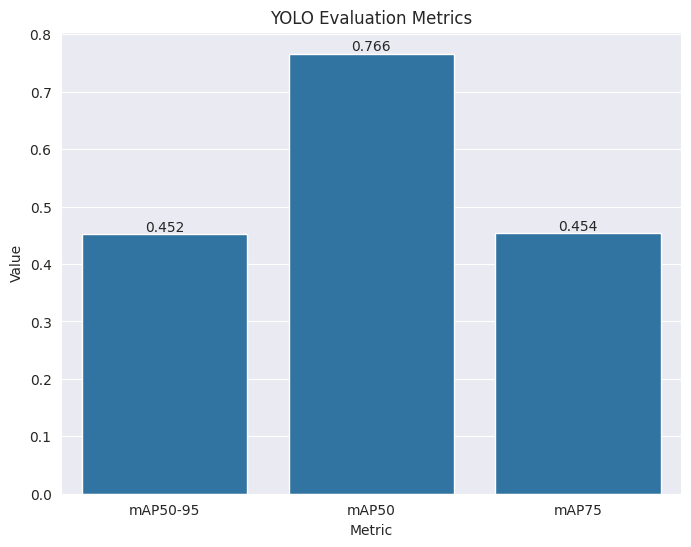

In [ ]:
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Show the plot
plt.show()

confusin matrix

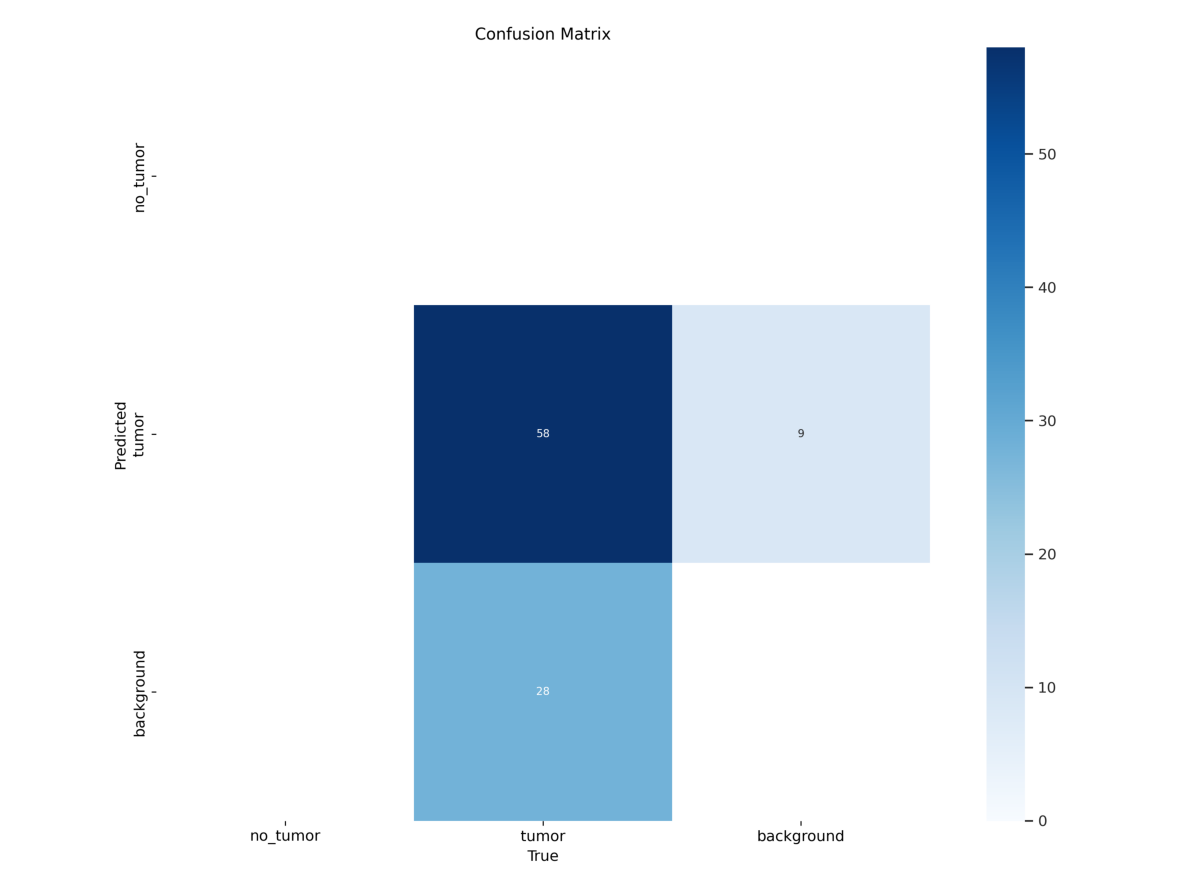

In [ ]:
# Reading the confusion matrix image file
img = mpimg.imread('/content/runs/detect/train/confusion_matrix.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off');

# **⚡Task2: Segmentation Full Images:**

## **✅Training Unet Model:**

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = []
        self.mask_files = []

        # Iterate through each subject folder
        for subject_folder in os.listdir(image_dir):
            subject_image_dir = os.path.join(image_dir, subject_folder)
            subject_mask_dir = os.path.join(mask_dir, subject_folder)

            # Ensure we are dealing with directories for both images and masks
            if os.path.isdir(subject_image_dir) and os.path.isdir(subject_mask_dir):
                # Get all image files in the current subject folder
                for img_file in os.listdir(subject_image_dir):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_path = os.path.join(subject_image_dir, img_file)
                        mask_path = os.path.join(subject_mask_dir, img_file)

                        # Check if corresponding mask exists
                        if os.path.isfile(mask_path):
                            self.image_files.append(image_path)
                            self.mask_files.append(mask_path)

        # Print the number of image-mask pairs found
        print(f"Found {len(self.image_files)} image-mask pairs.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get the image and mask paths
        image_path = self.image_files[idx]
        mask_path = self.mask_files[idx]

        # Load the image and its corresponding mask
        image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale (single channel)

        # Apply transformations to the image and mask separately
        if self.transform:
            # Apply transformations to the image
            image = self.transform(image)

            # Apply transformation to the mask (no normalization or scaling)
            # This ensures that the mask is still an integer type (important for segmentation)
            mask = self.transform(mask)

            # Ensure that mask is a binary tensor (0 or 1) for binary segmentation
            mask = mask.round()  # Round the mask to ensure it's binary (0 or 1)

        return image, mask, os.path.basename(image_path)


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Contracting path (Encoder)
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Expansive path (Decoder)
        self.decoder4 = self.upconv_block(1024, 512)
        self.decoder3 = self.upconv_block(512, 256)
        self.decoder2 = self.upconv_block(256, 128)
        self.decoder1 = self.upconv_block(128, 64)

        # Final convolution to match the output channels
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        # Sigmoid activation for binary segmentation (apply in forward pass)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU()
        )

    def forward(self, x):
        # Encoder path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        # Decoder path
        dec4 = self.decoder4(bottleneck)
        dec3 = self.decoder3(dec4 + enc4)
        dec2 = self.decoder2(dec3 + enc3)
        dec1 = self.decoder1(dec2 + enc2)

        # Final convolution
        output = self.final_conv(dec1 + enc1)

        # For binary segmentation, apply sigmoid (for multi-class segmentation use softmax)
        output = self.sigmoid(output)  # Apply sigmoid for binary classification

        return output


In [ ]:
# Function to calculate Dice coefficient
def dice_coefficient(preds, labels):
    smooth = 1e-6  # to avoid division by zero
    intersection = torch.sum(preds * labels)
    return (2. * intersection + smooth) / (torch.sum(preds) + torch.sum(labels) + smooth)

# Training function
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        train_dice = 0.0

        # Training phase
        for inputs, labels, filenames in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels.float())  # Ensure masks are float
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            preds = torch.sigmoid(outputs) > 0.5  # thresholding for binary segmentation
            correct_train += torch.sum(preds == labels).item()  # Correct predictions
            total_train += torch.numel(labels)  # Total pixels

            # Compute Dice coefficient
            train_dice += dice_coefficient(preds, labels).item()

        # Training accuracy, loss, and Dice score
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train * 100
        train_dice = train_dice / len(train_loader)

        # Evaluate on validation set
        val_loss, val_accuracy, val_dice = evaluate_model(model, val_loader, criterion, device)

        # Print metrics for the epoch
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Train Accuracy: {train_accuracy:.2f}% | "
              f"Train Dice: {train_dice:.4f} | "
              f"Validation Loss: {val_loss:.4f} | "
              f"Validation Accuracy: {val_accuracy:.2f}% | "
              f"Validation Dice: {val_dice:.4f}")

In [ ]:
# Function to save predicted masks (corrected path generation)
def save_predicted_masks(model, data_loader, phase, save_dir):
    model.eval()

    # Create a folder for the phase (train or val)
    phase_dir = os.path.join(save_dir, phase)
    os.makedirs(phase_dir, exist_ok=True)

    with torch.no_grad():
        for idx, (inputs, labels, filenames) in enumerate(tqdm(data_loader, desc=f"Saving {phase.capitalize()} Predicted Masks", leave=False)):
            inputs = inputs.to(device)
            outputs = model(inputs)

            # Apply sigmoid and threshold to get binary masks
            preds = torch.sigmoid(outputs) > 0.5

            # Convert predictions to a PIL Image and save with filenames
            for i in range(preds.size(0)):  # Loop through each image in the batch
                pred_mask = preds[i].cpu().squeeze(0)  # Remove batch and channel dimensions
                pred_mask = pred_mask.mul(255).byte()  # Convert mask to [0, 255] range (for saving)
                pred_mask_img = Image.fromarray(pred_mask.numpy())  # Convert to a PIL Image

                # Extract subject information from the filename (e.g., 'Subject_0_0.png')
                subject_name = filenames[i].split('_')[0]  # Assuming filenames like 'Subject_0_0.png'

                # Create a folder for each subject inside the 'train' or 'val' directory
                subject_folder = os.path.join(phase_dir, subject_name)  # Example: 'train/predicted_images_masks/Subject_0'

                # Create the directory if it doesn't exist
                os.makedirs(subject_folder, exist_ok=True)

                # Use the filename (e.g., 'Subject_0_0.png') for the mask file name
                mask_filename = filenames[i]  # Keep the original filename (e.g., 'Subject_0_0.png')

                # Save the predicted mask in the subject-specific folder
                mask_path = os.path.join(subject_folder, mask_filename)

                # Save the predicted mask image
                pred_mask_img.save(mask_path)


In [ ]:
# Evaluation function
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    total_correct = 0
    total_pixels = 0
    total_loss = 0.0
    val_dice = 0.0  # Store Dice score for validation
    with torch.no_grad():
        for inputs, labels, filenames in tqdm(val_loader, desc="Validating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels.float())
            total_loss += loss.item()

            # Thresholding for binary segmentation
            preds = torch.sigmoid(outputs) > 0.5

            total_correct += torch.sum(preds == labels).item()  # Correct predictions
            total_pixels += torch.numel(labels)  # Total pixels

            # Compute Dice coefficient
            val_dice += dice_coefficient(preds, labels).item()

    val_loss = total_loss / len(val_loader)
    val_accuracy = total_correct / total_pixels * 100
    val_dice = val_dice / len(val_loader)

    return val_loss, val_accuracy, val_dice


In [ ]:
if __name__ == "__main__":
    # Paths to your image and mask datasets
    train_image_dir = '/content/LungTumorDetectionAndSegmentation/train/images'
    train_mask_dir = '/content/LungTumorDetectionAndSegmentation/train/masks'
    val_image_dir = '/content/LungTumorDetectionAndSegmentation/val/images'
    val_mask_dir = '/content/LungTumorDetectionAndSegmentation/val/masks'

    # Define transformations (resize and convert to tensor)
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize both image and mask to 128x128
        transforms.ToTensor()
    ])

    # Create Datasets and DataLoaders
    train_dataset = SegmentationDataset(train_image_dir, train_mask_dir, transform)
    print(f"Number of training samples: {len(train_dataset)}")
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

    val_dataset = SegmentationDataset(val_image_dir, val_mask_dir, transform)
    print(f"Number of validation samples: {len(val_dataset)}")
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

    # Initialize the model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet(in_channels=3, out_channels=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    # Save directory for predicted masks
    save_dir = '/content/LungTumorDetectionAndSegmentation/predicted_masks'  # Update as needed

    # Train the model and save predicted masks
    for epoch in range(10):  # You can adjust the number of epochs as needed
        print(f"Epoch {epoch+1}/10")

        # Train the model
        train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=1)

        # Save predicted masks after each epoch (for training set)
        save_predicted_masks(model, train_loader, phase='train', save_dir=save_dir)

        # Save predicted masks after each epoch (for validation set)
        save_predicted_masks(model, val_loader, phase='val', save_dir=save_dir)


Found 1832 image-mask pairs.
Number of training samples: 1832
Found 98 image-mask pairs.
Number of validation samples: 98
Epoch 1/10


Epoch 1/1 | Train Loss: 0.7047 | Train Accuracy: 94.15% | Train Dice: 0.0005 | Validation Loss: 0.6931 | Validation Accuracy: 99.84% | Validation Dice: 0.0000


Epoch 2/10


Epoch 1/1 | Train Loss: 0.6931 | Train Accuracy: 99.53% | Train Dice: 0.0000 | Validation Loss: 0.6931 | Validation Accuracy: 99.84% | Validation Dice: 0.0000


Epoch 3/10


Epoch 1/1 | Train Loss: 0.6931 | Train Accuracy: 99.53% | Train Dice: 0.0022 | Validation Loss: 0.6931 | Validation Accuracy: 99.84% | Validation Dice: 0.0000


Epoch 4/10


Epoch 1/1 | Train Loss: 0.6931 | Train Accuracy: 99.53% | Train Dice: 0.0022 | Validation Loss: 0.6931 | Validation Accuracy: 99.84% | Validation Dice: 0.0000


Epoch 5/10


Epoch 1/1 | Train Loss: 0.6931 | Train Accuracy: 99.53% | Train Dice: 0.0000 | Validation Loss: 0.6931 | Validation Accuracy: 99.84% | Validation Dice: 0.0000


Epoch 6/10


Epoch 1/1 | Train Loss: 0.6931 | Train Accuracy: 99.53% | Train Dice: 0.0000 | Validation Loss: 0.6931 | Validation Accuracy: 99.84% | Validation Dice: 0.0000


Epoch 7/10


Epoch 1/1 | Train Loss: 0.6931 | Train Accuracy: 99.53% | Train Dice: 0.0000 | Validation Loss: 0.6931 | Validation Accuracy: 99.84% | Validation Dice: 0.0000


Epoch 8/10


Epoch 1/1 | Train Loss: 0.6931 | Train Accuracy: 99.53% | Train Dice: 0.0000 | Validation Loss: 0.6931 | Validation Accuracy: 99.84% | Validation Dice: 0.0000


Epoch 9/10


Epoch 1/1 | Train Loss: 0.6931 | Train Accuracy: 99.53% | Train Dice: 0.0022 | Validation Loss: 0.6931 | Validation Accuracy: 99.84% | Validation Dice: 0.0000


Epoch 10/10


Epoch 1/1 | Train Loss: 0.6931 | Train Accuracy: 99.53% | Train Dice: 0.0000 | Validation Loss: 0.6931 | Validation Accuracy: 99.84% | Validation Dice: 0.0000
